In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math,os
import cPickle as pickle

# from tqdm import tqdm,trange, tqdm_notebook
from tqdm import tqdm_notebook as tqdm
import numpy.linalg as npl
import itertools
import scipy.special,time, scipy.stats
from collections import Counter
from scipy.special import comb as choose

In [17]:
with open(r"pkls/adaSim_1199_0.pkl", "wb") as writeFile:
        pickle.dump({"strang":"hello world"}, writeFile)

In [24]:
myData = pickle.load( open( "pkls/adaSim_1199_1.pkl", "rb" ) )

In [27]:
def ceil(arr):
    return np.ceil(arr).astype(int)

def floor(arr):
    return np.floor(arr).astype(int)

In [28]:
def bruteForce(dataSet,maxPulls = -1):
    (n,d) = dataSet.shape
    estMeans = np.zeros(n)
    
    
    evalPts = np.logspace(0,np.log2(scipy.special.comb(n,d+1)),num=10,base=2,endpoint=True,dtype=int)
    if maxPulls != -1:
        evalPts = np.logspace(0,np.log2(maxPulls),num=10,base=2,endpoint=True,dtype=int)
#     evalPts = evalPts.astype(int)
#     print(evalPts)
    evalArgmax = np.zeros(len(evalPts))
    evalCtr = 0
    
    
    endIter = scipy.special.comb(n,d+1)
    if maxPulls!= -1:
        endIter = maxPulls
    
#     for i,tup in tqdm(enumerate(itertools.combinations(range(n),d+1)),total=endIter):
    for i,tup in enumerate(itertools.combinations(range(n),d+1)):
        refPts = dataSet[list(tup)]
        if maxPulls!= -1:
            refPts = dataSet[np.random.choice(n,d+1,replace=False)]
        
        X = refPts[:d].T - np.outer(refPts[-1], np.ones(d))

        queryPts = dataSet.T
        lamCoords = np.zeros((d+1,n))
        lamCoords[:d] = npl.solve(X,queryPts-np.outer(refPts[-1],np.ones(n)))

        lamCoords[-1] = 1-lamCoords.sum(axis=0)
        inSimplex = 1.0*np.all(lamCoords>-1*10**(-12),axis=0)
#         inSimplex[list(tup)]=.5
        estMeans += inSimplex
        
        if i==maxPulls:
            break
        if i==evalPts[evalCtr]:
            evalArgmax[evalCtr] = np.argmax(estMeans)
            evalCtr+=1
        
        
    evalArgmax[-1] = np.argmax(estMeans)
        
    if maxPulls!= -1:
        return evalArgmax,evalPts*n,estMeans/maxPulls
    return evalArgmax,evalPts*n,estMeans/scipy.special.comb(n,d+1)

In [29]:
#### Rousseuw and Ruts
# helpful ref https://github.com/olgazasenko/ColourfulSimplicialDepthInThePlane/blob/master/src/colourfulsimplicialdepthintheplane/RousseeuwAndRuts.java
def ruts2dDepth(data,point):
#     start = time.time()
    (n,d) = data.shape
    pi =np.pi
    
    alphaArr = np.zeros(n)
    for i in range(n):
        u = (data[i]-point)/np.linalg.norm(data[i]-point)
        alphaArr[i] = np.arctan2(u[1],u[0])
    
    alphaArr = np.sort(alphaArr)
    maxGap = max(2*np.pi+alphaArr[0] - alphaArr[-1],np.max(alphaArr[1:]-alphaArr[:-1]))
    if maxGap>np.pi:
#         print(r'max gap > $\pi$')
        return choose(n,2)/choose(n+1,3)
    alphaArr-= alphaArr[0]
    
    nu = max(np.where(alphaArr<np.pi)[0])+1

    betaArr = np.copy(alphaArr)-pi
    betaArr[alphaArr<pi] += 2*pi

    betaArr = np.sort(betaArr)
    
    
    mergedArr,wArr = mergeArrays(alphaArr,betaArr)
#     print(wArr)
    
    hi = np.zeros(n)
    hi[0]=nu-1
    startLoc = min(np.where(mergedArr>pi)[0])

    
#     startLoc = max(np.where(mergedArr==np.max(alphaArr[alphaArr<pi])))
    NF = nu
    t = 1
    i = startLoc
#     while t<n:
    while i!= startLoc-1:
        if wArr[i]==1:
            NF+=1
        else:
            hi[t] = NF-(t+1)
            t+=1
        i+=1
        i %= 2*n
        
#     print(time.time()-start)

    hiCheck = np.zeros(n)
    j=0
    for i in range(n):
#         j=i
        while True:
            if (alphaArr[i] <= alphaArr[j] and alphaArr[j]< alphaArr[i] + pi) or (alphaArr[j] < alphaArr[i]-pi):
                j+=1
                j%=n
            else:
                j-=1
                break
        
        if j < i:
            hiCheck[i] = j-i+n
        else:
            hiCheck[i]=j-i
#     print(hi)
#     print(hiCheck)
#     if not np.allclose(hi,hiCheck):
#         print(hi)
#         print(hiCheck)
#     print(np.allclose(hi,hiCheck))
#     print(hi)

#     print(time.time()-start)
    output = choose(n,3)
    for i in range(n):
        output-= choose(hiCheck[i],2)
    
#     print(time.time()-start)
    return (output+choose(n,2))/choose(n+1,3)
    

    
def mergeArrays(arr1, arr2):
    n = len(arr1)
    arr3 = np.zeros(2*n)
    i = 0
    j = 0
    k = 0
    w = np.zeros(2*n)
    
#     print('w',w)
    # Traverse both array
    while i < n and j < n:
        if arr1[i] < arr2[j]:
            arr3[k] = arr1[i]
            w[k]=1
            k = k + 1
            i = i + 1
            
        else:
            arr3[k] = arr2[j]
            w[k]= -1
            k = k + 1
            j = j + 1
            
     
 
    # Store remaining elements
    # of first array
    while i < n:
        arr3[k] = arr1[i];
        w[k]=1
        k = k + 1
        i = i + 1
        
 
    # Store remaining elements
    # of second array
    while j < n:
        arr3[k] = arr2[j];
        w[k]=-1
        k = k + 1
        j = j + 1
        
    return arr3,w

In [30]:
def bestArm(dataSet,eps,delta):
    n,d = dataSet.shape
    r=1
    activeArmsArr = np.ones(n,dtype=bool)
    activeArmsSet = set(range(n))
    estMeans = np.zeros(n)
    numPulls = np.zeros(n)
    trPrev = 0
    
    
    while True:
        epsR = (1/2)**r
        trTotal = ceil(.2*epsR**(-2)*np.log(4*n*r**2/delta))
        tr=trTotal - trPrev
        trPrev = trTotal
        
        nr = len(activeArmsSet)
        tr = int(min(tr,scipy.special.comb(n,d+1)))
#         print("r={},tr={},nr={}".format(r,tr,nr))
        
        threshold = int(5*n*np.log2(n))
        if tr>threshold and d==2:
            exactComputeIdx = list(activeArmsSet)
            exactComputeVal = np.zeros(len(exactComputeIdx))
            for (i,idx) in enumerate(exactComputeIdx):
                exactComputeVal[i] = ruts2dDepth(np.delete(dataSet,idx,axis=0),dataSet[idx])
                estMeans[idx]=exactComputeVal[i]
                numPulls[idx] += threshold
#             print('short circuiting')
#             print(exactComputeIdx)
#             print(exactComputeVal)
#             print(exactComputeIdx[exactComputeVal.argmax()])
            return exactComputeIdx[exactComputeVal.argmax()],estMeans,numPulls,len(activeArmsSet)
        
        
        #### pull arms
        Yr = np.zeros((len(activeArmsSet),tr))
        myit = itertools.combinations(range(n),d+1)
        for j in range(tr):
            refIdxs = np.random.choice(n,size=d+1,replace=False)
            
            if tr==scipy.special.comb(n,d+1):
                refIdxs = next(myit)
            
            refPts = dataSet[refIdxs]
            X = refPts[:d].T - np.outer(refPts[-1], np.ones(d))
            
            queryPts = dataSet[activeArmsArr].T
            lamCoords = np.zeros((d+1,nr))
            lamCoords[:d] = npl.solve(X,queryPts-np.outer(refPts[-1],np.ones(nr)))

            lamCoords[-1] = 1-lamCoords.sum(axis=0)
#             print(lamCoords.shape)
#             inSimplex = np.maximum(1.0*np.all(lamCoords>-1*10**(-12),axis=0)-.5*np.any(lamCoords>1-10**(-12),axis=0),0)
            inSimplex = 1.0*np.all(lamCoords>-1*10**(-12),axis=0)

    
            Yr[:,j] = inSimplex
            
        estMeans[activeArmsArr] = (numPulls[activeArmsArr]*estMeans[activeArmsArr] + Yr.sum(axis=1))/(numPulls[activeArmsArr]+tr)
        numPulls[activeArmsArr]+=tr
        ### end pull arms
        
        maxVal = estMeans[activeArmsArr].max()
        newActive = set()
        activeArmsArr=np.zeros(n,dtype=bool)
#         print(estMeans[28],maxVal-epsR)
        for i in activeArmsSet:
            if estMeans[i]> maxVal-epsR:
                newActive.add(i)
                activeArmsArr[i]=True
        activeArmsSet = newActive

        if len(activeArmsSet)==1 or epsR <= eps/2 or tr>=scipy.special.comb(n,d+1):
            return np.argmax(estMeans+100*activeArmsArr),estMeans,numPulls,0
    
        r+=1

In [36]:
# n= 100
# d=2
# dataSet = np.random.normal(size=(n,d))




d=2
numTrials = 6
# deltaArr = [.0001,.01,1]
delta = .001
epsilon=.000001
# nArr = [500]
nArr=[250,268,284,300]
# nArr = np.round(np.logspace(np.log2(200),np.log2(20000),num=15,base=2)).astype(int)
print(nArr)

simTimes = np.zeros((len(nArr),numTrials))
simResult = np.zeros((len(nArr),numTrials))
simNumPulls = np.zeros((len(nArr),numTrials))
numExactCompArr = np.zeros((len(nArr),numTrials))
numPullsPerArm = []

brutePulls = np.zeros((len(nArr),10))
bruteResults=np.zeros(brutePulls.shape)
bruteTimes = np.zeros(len(nArr))

rutsResult = np.zeros(len(nArr))
rutsTimes = np.zeros(len(nArr))
rutsTotalDepths = []

# for (i,n) in enumerate(nArr):
for (i,n) in tqdm(enumerate(nArr),total=len(nArr)):
    np.random.seed(0)
    dataSet = np.random.normal(size=(n,d))

    numPullsArr = np.zeros(n)
    for j in range(numTrials):
        if j%2 ==0:
            dataSet = np.random.normal(size=(n,d))
#         np.random.seed(i)
        start = time.time()
        idx,estMeans,numPulls,numExactComp = bestArm(dataSet,epsilon,delta)
        simResult[i,j] = idx
        simNumPulls[i,j] = numPulls.sum()
        simTimes[i,j] = time.time()-start
        numExactCompArr[i,j] = numExactComp
        numPullsArr += numPulls
    numPullsPerArm.append(numPullsArr/numTrials)
#     print(simResult[i])

    continue
    start = time.time()
    maxBrutePull = 10000
    evalArgmax,evalPts,estMeansBrute = bruteForce(dataSet,maxPulls=maxBrutePull)
    brutePulls[i] = evalPts
    bruteResults[i] = evalArgmax
    bruteTimes[i] = (time.time()-start)*scipy.special.comb(n,d+1)/maxBrutePull


    ### get timing for ruts
    start=time.time()
    bruteCompNum = 50
    rutsDepth = np.zeros(n)
    for j in range(bruteCompNum):
        rutsDepth[j] = ruts2dDepth(np.delete(dataSet,j,axis=0),dataSet[j])
    rutsTimes[i]= (time.time()-start)*n/bruteCompNum
    
    ### actually compute ruts depth
#     start = time.time()
#     rutsDepth = np.zeros(n)
#     for j in tqdm(range(n)):
#         rutsDepth[j] = ruts2dDepth(np.delete(dataSet,j,axis=0),dataSet[j])

#     rutsResult[i] = np.argmax(rutsDepth)
#     rutsTimes[i] = time.time()-start
#     rutsTotalDepths.append(rutsDepth)
#     print(rutsTime)

[250, 268, 284, 300]


In [ ]:
# np.savez('plots/data20k.npz', nArr=nArr,bruteTimes=bruteTimes, rutsTimes = rutsTimes, simTimes = simTimes,
#         simNumPulls = simNumPulls, numPullsPerArm = numPullsPerArm)

In [ ]:
import pickle
import itertools


itertools.product()

for (i,n) in tqdm(enumerate(nArr),total=len(nArr)):


    for j in range(numTrials):
        numPullsArr = np.zeros(n)
        np.random.seed(j//2)
        
        dataSet = np.random.normal(size=(n,d))
        np.random.seed(j)

        
        start = time.time()
        idx,estMeans,numPulls,numExactComp = bestArm(dataSet,epsilon,delta)
        
        totalTime = time.time()-start
#         simResult[i,j] = idx
#         simNumPulls[i,j] = numPulls.sum()
#         simTimes[i,j] = time.time()-start
#         numExactCompArr[i,j] = numExactComp
#         numPullsArr += numPulls
#         pickle.dump([colProbStoreArrAll,colProbStoreArrMean,argminKmerProb,
# 		"colProbStoreArrAll, colProbStoreArrMean, argminKmerProb"],
# 		open("AUCs/{}_colProb.pkl".format(dataset[:-1]), "wb" ) )
        
        pickle.dump([j//2,j,n,idx,numExactComp,numPulls,estMeans,"dataSeed","trial num","n","numExactComp","numPulls","estMeans"],
                    open("pkls/{}_{}_adaSim.pkl".format(n,j), "wb" ) )
#     numPullsPerArm.append(numPullsArr/numTrials)
#     print(simResult[i])

In [ ]:
# np.savez('plots/data8k.npz', nArr=nArr,bruteTimes=bruteTimes, rutsTimes = rutsTimes, simTimes = simTimes,
#         simNumPulls = simNumPulls, numPullsPerArm = numPullsPerArm)

In [35]:
print(simTimes.mean(axis=1))

[1.91322462 1.75114075 4.01411339]


In [ ]:
rutsTimes

/home/tavorb/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/home/tavorb/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2320: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/tavorb/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


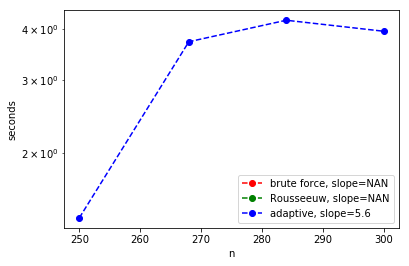

In [37]:
# plt.figure()
fig1, ax1 = plt.subplots()

s=0
bruteSlope,_,_,_,_ = scipy.stats.linregress(np.log(nArr)[s:], np.log(bruteTimes)[s:])
rutSlope,_,_,_,_ = scipy.stats.linregress(np.log(nArr)[s:], np.log(rutsTimes)[s:])
adaSlope,_,_,_,_ = scipy.stats.linregress(np.log(nArr)[s:], np.log(simTimes.mean(axis=1)[s:]))


plt.plot(nArr,bruteTimes,'--o',color='r',label='brute force, slope={:.1F}'.format(bruteSlope))
plt.plot(nArr,rutsTimes,'--o',color='g',label='Rousseeuw, slope={:.1F}'.format(rutSlope))
plt.plot(nArr,simTimes.mean(axis=1),'--o',color='b',label='adaptive, slope={:.1F}'.format(adaSlope))
# plt.plot(nArr,np.median(simTimes,axis=1),'--o',color='y',label='adaptive, slope={:.1F}'.format(adaSlope))

# plt.errorbar(nArr,simTimes.mean(axis=1),yerr=4*np.var(simTimes,axis=1)**(.5),fmt='--o',color='y',label='adaptive, slope={:.1F}'.format(adaSlope))

# plt.plot(nArr,bruteTimes,'--o',color='r',label='brute force')
# plt.plot(nArr,rutsTimes,'--o',color='g',label='Rousseeuw')
# plt.plot(nArr,simTimes.mean(axis=1),'--o',color='b',label='adaptive')
plt.yscale('log')
# plt.xscale('log')
plt.ylabel('seconds')
plt.xlabel('n')
# plt.title(r'Simplicial median computation for $d=2$')
plt.legend()

# ax1.set_xscale('log')
# ax1.set_xticks([200,2000,20000])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# plt.show()
# plt.savefig('plots/adaWithRousseeuw2d_20k.pdf')

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(nArr)[-5:], np.log(simTimes.mean(axis=1))[-5:])
print(slope)

In [ ]:
yVals = [scipy.special.comb(n,3) for n in nArr]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(nArr), np.log(yVals))
print(slope)

In [ ]:
plt.plot(nArr,np.mean(numExactCompArr,axis=1)/nArr,'--o')
# plt.title('Fraction of simplicial depths exactly computed')
plt.ylabel('fraction')
plt.xlabel('n')
ax=plt.gca()
ax.set_xscale('log')
ax.set_xticks([200,2000,20000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# plt.show()
# plt.savefig('plots/ada2dFracExactComp20k.pdf')

In [ ]:
idx = 2
threshold = int(5*n*np.log2(n))
gaps = rutsTotalDepths[idx].max()-rutsTotalDepths[idx]
plt.figure()
plt.scatter(gaps[gaps>0]**(-2),numPullsPerArm[idx][gaps>0],alpha=.5, label='Cost per data point')
plt.axhline(threshold, linestyle='--',c='r', label='Exact computation cost')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Inverse gap squared $\Delta_i^{-2}$')
plt.ylabel('Number of pulls')
plt.title('Number of computations used per point \n' r'for $n=500,d=2$')

x = gaps[gaps>0]**(-2)
y=numPullsPerArm[idx][gaps>0]
x = x[y<threshold]
y = y[y<threshold]

coefs = np.polynomial.polynomial.Polynomial.fit(x,y,1).convert().coef

plt.plot(x,coefs[0]+coefs[1]*x,'--r')

plt.legend()
# plt.savefig('plots/pullsVsGap.pdf')

In [ ]:
x = gaps[gaps>0]**(-2)
y=numPullsPerArm[idx][gaps>0]
x = x[y<threshold]
y = y[y<threshold]

# np.polynomial.polynomial.Polynomial.fit(x,y,1).convert().coef
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

In [ ]:
r_value**2

In [ ]:
### plotting gap hist
gaps = []
for _ in tqdm(range(10)):
    n = 50
    dataset = np.random.normal(size=(n,d))
    rutsDepth = np.zeros(n)
    for j in tqdm(range(n)):
        rutsDepth[j] = ruts2dDepth(np.delete(dataSet,j,axis=0),dataSet[j])
    gapArr = rutsDepth.max() - rutsDepth
    gaps.append(list(gapArr[gapArr>0]))

In [ ]:
gaps = [x for lst in gaps for x in lst]

In [ ]:
# gaps = rutsDepth.max() - rutsDepth
# gaps = gaps[gaps>0]
plt.hist(gaps,bins=20)

In [ ]:
# bestPt = int(Counter(bruteResults[:,-1]).most_common(1)[0][0]) 
# bestPt = bruteResults[0,-1]
bestPt = Counter(simResult.flatten()).most_common(1)[0][0].astype(int)

plt.figure()
plt.scatter(simNumPulls.mean(axis=1),1-(simResult==bestPt).mean(axis=1),c='r',label='adaptive')

bruteArr = np.mean(bruteResults==bestPt,axis=0)
# w = 4
# toPlot = np.convolve(bruteArr,np.ones(w),'same')/w
# toPlot[-w:] = bruteArr[-w:]
plt.plot(evalPts,1-bruteArr,'--bo',label='uniform sampling')
plt.axvline(n*scipy.special.comb(n,d+1),color='b', linestyle='--',label='brute force')

plt.ylim([-.05,1])
plt.xlim(left=1)
plt.xscale('log')
plt.xlabel('Number of linear system solves')
plt.ylabel('Error probability')
plt.title('N = {}, d = {} \n Exact: 2hr, Adaptive: 5s'.format(n,d))
plt.legend()
# plt.savefig('plots/n{}d{}manipulatedConf.pdf'.format(n,d))

In [ ]:
_=ruts2dDepth(np.random.normal(size=(1000,2)),np.zeros(2))

In [ ]:
randDataset = np.random.normal(size=(20,2))
randQuery = np.random.normal(size=2)
print("depth is", ruts2dDepth(np.delete(randDataset,0,axis=0),randDataset[0]))
evalArgmax,evalPts,estMeansBrute = bruteForce(randDataset)
print("depth is",estMeansBrute[0])

In [ ]:
### Aug 7 testing ruts alg

nTest = nArr
rutsTest = []
for n in tqdm(nTest):
    dataset = np.random.normal(size=(n,2))
    start = time.time()
    
    for _ in range(10):
        _=ruts2dDepth(dataset,np.zeros(2))
    rutsTest.append((time.time()-start)/10)

In [ ]:
ruts2dDepth(thetaToXY([0,pi/3,7*pi/4,pi/2+eps,pi,3*pi/2-eps]),[0,0])

In [ ]:
def thetaToXY(thetaArr):
    dataArr = np.zeros((len(thetaArr),2))
    dataArr[:,0] = np.cos(thetaArr)
    dataArr[:,1] = np.sin(thetaArr)
    
    return dataArr

In [ ]:
pi=np.pi
thetaToXY([0,pi/3,7*pi/4,pi/2,pi,3*pi/2])

In [ ]:
ruts2dDepth(thetaToXY([0,pi/3,7*pi/4,pi/2+eps,pi,3*pi/2-eps]),[0,0])

In [ ]:
eps=.000001
data = thetaToXY([0,pi/3,7*pi/4,pi/2+eps,pi,3*pi/2-eps])
plt.scatter(data[:,0],data[:,1])
plt.scatter(0,0)

In [ ]:
data = thetaToXY([0,0,pi/3,7*pi/4,pi/2+eps,pi,3*pi/2-eps])
data[0]=[0,0]
bruteForce(data)[-1]*choose(data.shape[0],3)

## graveyard below

In [ ]:
queryPt = np.array([.2,0])
refPts = dataSet[[1,2,3]]
print(queryPt)
print(refPts)

In [ ]:
plt.scatter(refPts[:,0],refPts[:,1],c='r')
plt.plot(refPts[:,0],refPts[:,1],c='r')
plt.plot([refPts[-1,0],refPts[0,0]],[refPts[-1,1],refPts[0,1]],c='r')
plt.scatter(queryPt[0],queryPt[1],c='b')
# plt.scatter(.6,1.9)

In [ ]:
X = refPts[:d].T - np.outer(refPts[-1], np.ones(d))

In [ ]:
lamCoords = np.zeros(d+1)
# lamCoords[:d] = npl.inv(X).dot(queryPt-refPts[-1])
# lamCoords[:d] = npl.solve(X,queryPt-refPts[-1])

multQueries = np.array([refPts[-1],[.6,1.9],[.2,0]]).T
lamCoords = np.zeros((d+1,3))
lamCoords[:d] = npl.solve(X,multQueries-np.outer(refPts[-1],np.ones(multQueries.shape[1])))

lamCoords[-1] = 1-lamCoords.sum(axis=0)
print(lamCoords)

In [ ]:
multQueries-np.outer(refPts[-1],np.ones(multQueries.shape[1]))

In [ ]:
idx,estMeans,numPulls = bestArm(dataSet,.1,.01)

In [ ]:
plt.scatter(dataSet[:,0],dataSet[:,1],c='b')
plt.scatter(dataSet[3,0],dataSet[3,1],c='r')

In [ ]:
plt.scatter(npl.norm(dataSet-dataSet.mean(axis=0),axis=1),numPulls)

In [ ]:
for i in tqdm(range(numTrials)):
    np.random.seed(i)
    start = time.time()
    idx,estMeans,numPulls,numExactComp = bestArm(dataSet,0.000001,delta)
    mid = time.time()
    simResult[j,i] = idx
    simNumPulls[j,i] = numPulls.sum()
    simTimes[j,i] = mid-start
    numExactCompArr[j,i] = numExactComp

    
bruteTrials = 1
brutePulls = np.zeros(10)
bruteResults = np.zeros(10)
bruteTimes = np.zeros(bruteTrials)
for i in range(bruteTrials):
    print(i)
#     np.random.seed(i)
    start = time.time()
    maxPullVal = 30000
    evalArgmax,evalPts,estMeansBrute = bruteForce(dataSet,maxPulls=maxPullVal)

#     evalArgmax,evalPts,estMeansBrute = bruteForce(dataSet[np.random.permutation(n)])
    brutePulls = evalPts
    bruteResults[i] = evalArgmax
    bruteTimes[i] = (time.time()-start)*scipy.special.comb(n,d+1)/maxPullVal

    
start=time.time()
rutsDepth = np.zeros(n)
for i in tqdm(range(n)):
    rutsDepth[i] = ruts2dDepth(np.delete(dataSet,i,axis=0),dataSet[i])
    
rutsResult = np.argmax(rutsDepth)
rutsTime = time.time()-start
print(rutsTime)